In [20]:
##Libraries##

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import insert
import pyodbc
import numpy as np
import matplotlib.pyplot as plt




In [193]:
##Connection to cmv_uat database##

server = 'tcp:mycmvserver.database.windows.net' 
database = 'cmvdb_uat' 
username = 'ecervantes@cmvlatam.com' 
password = 'Columbia87/' 


connection = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};Server=tcp:mycmvserver.database.windows.net,1433;Database=cmvdb_uat;Uid='+username+';Pwd='+password+';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;Authentication=ActiveDirectoryInteractive')
cursor = connection.cursor()

In [200]:
ncliente =  114049##Blotter + last 5 trades ### 
query = "SELECT * FROM [dbo].[fxblotter.t]"
# Read the SQL query into a DataFrame
fxblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
fxblotter.sort_index(inplace=True)
#datetime format#
fxblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
fxblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
fxblottert = fxblotter.loc[fxblotter['clienteid'] == ncliente]
## filtro para accionid, escencialmente deja los Lost deals por fuera del calculo ##
fxblottert = fxblottert[fxblottert['accionid'] == 1] ### acepting 'addnew', 'lost' do not count for spread analysis##

query = "SELECT * FROM [dbo].[cstats]"
# Read the SQL query into a DataFrame
cstatsblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
cstatsblotter.sort_index(inplace=True)
#datetime format#
cstatsblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
cstatsblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
cstatsblottert = cstatsblotter.loc[cstatsblotter['clienteid'] == ncliente]
ccstatsblottert = cstatsblottert.copy() ## to solve chained assigement error
#won/lost format#
ccstatsblottert.loc[ccstatsblottert['accionid'] == 1, 'accionid'] = 'won'
ccstatsblottert.loc[ccstatsblottert['accionid'] == 4, 'accionid'] = 'lost'
ccstatsblottert.tail(5)

##fxblottert.head(5)

,descliente,tradedate,accionid,side,px_sp,px_cover,monex_pxlast,monex_pp,ejecutivo,comccy,montocom,venccy,montoven,valuedate,dealer,clienteid
tradeid,,,,,,,,,,,,,,,,
202107010003889,TREJOS VELAZQUEZ NORA ISABEL,2021-07-01,won,Bid,617.25,619.25,619.75,619.55,None,USD,1174.564601,CRC,7.250000e+05,2021-07-01,Esteban Cervantes,114049
202107050003932,TREJOS VELAZQUEZ NORA ISABEL,2021-07-05,won,Bid,617.55,619.25,620.14,619.86,None,USD,27951.670000,CRC,1.726155e+07,2021-07-05,Esteban Cervantes,114049
202107060003939,TREJOS VELAZQUEZ NORA ISABEL,2021-07-06,won,Bid,617.75,619.40,620.20,620.02,None,USD,2185.350000,CRC,1.350000e+06,2021-07-06,Esteban Cervantes,114049
202107090004007,TREJOS VELAZQUEZ NORA ISABEL,2021-07-09,won,Bid,619.00,622.25,622.75,622.63,None,USD,969.310000,CRC,6.000029e+05,2021-07-09,Esteban Cervantes,114049
202107090004008,TREJOS VELAZQUEZ NORA ISABEL,2021-07-09,won,Bid,619.00,620.50,621.60,622.14,None,USD,1615.510000,CRC,1.000001e+06,2021-07-09,Esteban Cervantes,114049


In [ ]:
ccstatsblottert.info()

3 day rolling blended spread DDDEEEVVV
Last
tradedate
2021-07-09    3.013333
Name: spreadbidmpp, dtype: float64
                                         
Bid Spread to Monex P.P :  1.723 CRC
Bid Spread to Cover P.P :  1.393 CRC
Bid Spread to Monex last traded PX :  1.447 CRC
                                         
Bid monto promedio por transaccion :  24,590.313 USD
Bid total millage :  323,684.0 USD
Bids traded :  78 
                                         
************************************************************************************
3 day rolling blended spread DDDEEEVVV
Last
tradedate
2020-12-09   NaN
Name: spreadaskmpp, dtype: float64
                                         
Ask Spread to Monex P.P :  -6.49 CRC
Ask Spread to Cover P.P :  -6.49 CRC
Ask Spread to Monex last traded PX :  -6.49 CRC
                                         
Bid monto promedio por transaccion :  nan USD
Ask total millage :  7,471.0 USD
Asks :  1
                                         
*****

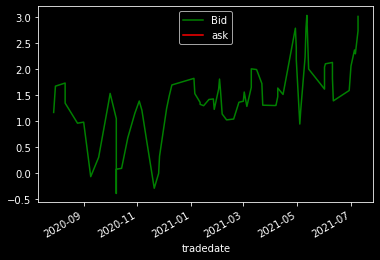

In [201]:
### C-Stats
#info ya viene con filtro por cliente
#Filtro el blotter por bid y ask y creo dos dataframe separados
#bid
bidfxblotter = fxblottert.loc[fxblottert['comccyid'] == 1 ]
bidblotter = bidfxblotter.copy() ## to solve chained assigement error
bidblotter = bidblotter.set_index('tradedate')
#ask
askfxblotter = fxblottert.loc[fxblottert['venccyid'] == 1 ] 
askblotter = askfxblotter.copy() ## to solve chained assigement error
askblotter = askblotter.set_index('tradedate')
#Calculo de Spreads 
bidblotter['spreadbidmpp'] =  bidblotter['monex_pp'] - bidblotter['px_sp'] #diff contra Monex PP
bidblotter['spreadbidpxc'] =  bidblotter['px_cover'] - bidblotter['px_sp'] #diff contra Cover
bidblotter['spreadbidpxl'] =  bidblotter['monex_pxlast'] - bidblotter['px_sp'] #diff contra ultimo de Monex

askblotter['spreadaskmpp'] =  askblotter['px_sp'] - askblotter['monex_pp'] #diff contra Monex PP
askblotter['spreadaskpxc'] =  askblotter['px_sp'] - askblotter['px_cover'] #diff contra Cover
askblotter['spreadaskpxl'] =  askblotter['px_sp'] - askblotter['monex_pxlast'] #diff contra ultimo de Monex

# Q de trades
bidcount = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].count()
askcount = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].count()
# Monto promedio por ticket
bidmontoavg =  bidfxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].mean()
askmontoavg = askfxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].mean( )
# Millage total del cliente
bidsum = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].sum()
asksum = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].sum()
##blendedspread = 

#sumo todos los colones y todos los dolares, y calculo los dolares a tasa de cover 
print('3 day rolling blended spread DDDEEEVVV')
print('Last')
print(bidblotter['spreadbidmpp'].rolling(window=3).mean().tail(1))
print("                                         ")
print1 ="Bid Spread to Monex P.P :  {:,} CRC"
print(print1.format(round(spreadbidmpp,3)))
print1 ="Bid Spread to Cover P.P :  {:,} CRC"
print(print1.format(round(bidblotter['spreadbidpxc'].mean(),3)))
print1 ="Bid Spread to Monex last traded PX :  {:,} CRC"
print(print1.format(round(bidblotter['spreadbidpxl'].mean(),3)))
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print("                                         ")
print(print1.format(round(bidmontoavg,3)))
print1 ="Bid total millage :  {:,} USD"
print(print1.format(round(bidsum,0)))
print1 ="Bids traded :  {:,} "
print(print1.format(bidcount))
print("                                         ")
print("************************************************************************************")
print('3 day rolling blended spread DDDEEEVVV')
print('Last')
print(askblotter['spreadaskmpp'].rolling(window=3).mean().tail(1))
print("                                         ")
print1 ="Ask Spread to Monex P.P :  {:,} CRC"
print(print1.format(round(askblotter['spreadaskmpp'].mean(),3)))
print1 ="Ask Spread to Cover P.P :  {:,} CRC"
print(print1.format(round(askblotter['spreadaskpxc'].mean(),3)))
print1 ="Ask Spread to Monex last traded PX :  {:,} CRC"
print(print1.format(round(askblotter['spreadaskpxl'].mean(),3)))
print("                                         ")
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print(print1.format(round(askmontoavg,3)))
print1 ="Ask total millage :  {:,} USD"
print(print1.format(round(asksum,0)))
print1 ="Asks :  {:,}"
print(print1.format(askcount))
print("                                         ")
print("************************************************************************************")
print("                                         ")
print(fxblottert['tradedate'].dt.day_name().value_counts())

#graphs and visuals

bidrolling = bidblotter['spreadbidmpp'].rolling(window=3).mean()
askrolling = askblotter['spreadaskmpp'].rolling(window=3).mean()

#fig, (ax1, ax2) = plt.subplots()
plt.style.use('dark_background')
bidrolling.plot( color='green', label="Bid") 
askrolling.plot(color='red', label="ask")
ax = plt.gca()
ax.legend(loc='upper center')
##ax.patch.set_facecolor('blue')
##ax.set_axis_bgcolor('blue')
#ax.set_xlabel(fontcolor='red')
#ax1.set_xlabel(bidblotter['tradedate']) 
#ax2.set_xlabel(askblotter['spreadaskmpp'])  

##  = plt.subplots(,askblotter['spreadaskmpp'].rolling(window=3).mean())

#bidrolling.plot.line( label = "spread",xlabel = "tradedate 3Day Rolling Spread")
#askrolling.plot.line( label = "spread",xlabel = "tradedate 3Day Rolling Spread")
##Agregar Histograma para este ultimo print
##fxblottert['tradedate'].dt.day_name().value_counts().hist(bins = day_name())

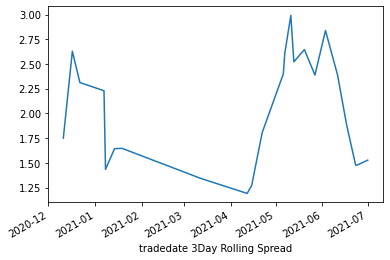

In [133]:
#####     DEV           ### C-Stats
#info ya viene con filtro por cliente
#Filtro el blotter por bid y ask y creo dos dataframe separados

bidfxblotter = fxblottert.loc[fxblottert['comccyid'] == 1 ]
bidblotter = bidfxblotter.copy() ## to solve chained assigement error
bidblotter = bidblotter.set_index('tradedate')
#bidfxblottert.sort_index(inplace=True)

bidblotter['spreadbidmpp']  =  bidblotter['monex_pp'] - bidblotter['px_sp']
#bidblotter['spreadbidmpp'].tail()
bidblotter['spreadbidmpp'].rolling(window=3).mean().tail(1)
#bidblotter.describe()
#bidblotter.dtypes
#bidblotter.info()
#spreadbidmpp.rolling(window=5).mean()
bidrolling = bidblotter['spreadbidmpp'].rolling(window=3).mean().plot.line( label = "spread",xlabel = "tradedate 3Day Rolling Spread")
#ax.set_axis_color('yellow')

In [ ]:
#####     DEV           ###

##spread.plot()##
spreadbidmpp.plot.line( label = "spread",xlabel = "tradedate")
spreadbidpxc.plot.line(label = "spread",xlabel = "tradedate")
spreadbidpxl.plot.line(label = "spread",xlabel = "tradedate")
plot.show()


spreadaskmpp.plot.line(label = "spread",xlabel = "tradedate")
spreadaskpxc.plot.line(label = "spread",xlabel = "tradedate")
spreadaskpxl.plot.line(label = "spread",xlabel = "tradedate")
plot.show()

In [ ]:
#####     DEV           ###

pip install matplotlib
